In [ ]:
!source /opt/xilinx/xrt/setup.sh

In [2]:
!xbutil examine -d0000:08:00.1 -r thermal


------------------------------------------------------
1/1 [0000:08:00.1] : xilinx_u50_gen3x16_xdma_201920_3
------------------------------------------------------
Thermals
  PCB Top Front          : 42 C
  PCB Top Rear           : 44 C
  FPGA                   : 52 C
  FPGA HBM               : 47 C



In [1]:
import pynq
import numpy as np

from pynq import allocate
from pynq import Overlay

from matplotlib import pyplot as plt
from datetime import datetime

/home/ubuntu/anaconda3/envs/hls4ml_env/lib/python3.9/site-packages/pynq/pl_server/xrt_device.py:88: UserWarning: xbutil failed to run - unable to determine XRT version
  warnings.warn(


In [2]:
class NeuralNetworkOverlay(Overlay):
    def __init__(self, xclbin_name, dtbo=None, download=True, ignore_version=False, device=None):

        super().__init__(xclbin_name, dtbo=dtbo, download=download, ignore_version=ignore_version, device=device)

    def allocate_mem(self, X_shape, y_shape, dtype=np.float32, trg_in=None, trg_out=None):
        """
        Buffer allocation in the card memory
        Parameters
        ----------
        X_shape : input buffer shape.
        y_shape : output buffer shape.
        dtype   : the data type of the elements of the input/output vectors.
                  Note: it should be set depending on the interface of the accelerator; if it uses 'float'
                  types for the 'data' AXI-Stream field, 'np.float32' dtype is the correct one to use.
                  Instead if it uses 'ap_fixed<A,B>', 'np.intA' is the correct one to use (note that A cannot
                  any integer value, but it can assume {..., 8, 16, 32, ...} values. Check `numpy`
                  doc for more info).
                  In this case the encoding/decoding has to be computed by the host machine. For example for
                  'ap_fixed<16,6>' type the following 2 functions are the correct one to use for encode/decode
                  'float' -> 'ap_fixed<16,6>':
                  ```
                    def encode(xi):
                        return np.int16(round(xi * 2**10)) # note 2**10 = 2**(A-B)
                    def decode(yi):
                        return yi * 2**-10
                    encode_v = np.vectorize(encode) # to apply them element-wise
                    decode_v = np.vectorize(decode)
                  ```
        trg_in  : input buffer target memory, alveo-u50 has 32 bank of HBM 256 MB each. By default the v++ command
                  set it to HBM[0].
        trg_out : output buffer target memory, alveo-u50 has 32 bank of HBM 256 MB each. By default the v++ command
                  set it to HBM[0].

        Returns
        -------
        input_buffer, output_buffer : input and output PYNQ buffers

        """
        input_buffer  = allocate(shape=X_shape, dtype=dtype, target=trg_in )
        output_buffer = allocate(shape=y_shape, dtype=dtype, target=trg_out)
        return input_buffer, output_buffer

    def predict(self, X, y_shape, input_buffer, output_buffer, debug=None, profile=False, encode=None,
                decode=None):
        """
        Obtain the predictions of the NN implemented in the FPGA.
        Parameters:
        - X : the input vector. Should be numpy ndarray.
        - y_shape : the shape of the output vector. Needed to the accelerator to set the TLAST bit properly and
                    for sizing the output vector shape.
        - input_buffer : input PYNQ buffer, must be allocated first and just once.
        - output_buffer : output PYNQ buffer, must be allocated first and just once.
        - debug : boolean, if set the function will print information about the data transfers status.
        - profile : boolean. Set it to `True` to print the performance of the algorithm in term of `inference/s`.
        - encode/decode: function pointers. See `dtype` section for more information.
        - return: an output array based on `np.ndarray` with a shape equal to `y_shape` and a `dtype` equal to
                  the namesake parameter.
        """
        if profile:
            timea = datetime.now()
        if encode is not None:
            X = encode(X)
        in_size  = np.prod(X.shape)
        out_size = np.prod(y_shape)
        input_buffer[:] = X
        input_buffer.sync_to_device()
        if debug:
            print("Send OK")
        self.krnl_rtl_1.call(input_buffer, output_buffer, in_size, out_size)
        if debug:
            print("Kernel call OK")
        output_buffer.sync_from_device()
        if debug:
            print("Recieve OK")
        result = output_buffer.copy()
        if profile:
            timeb = datetime.now()
            dts, rate = self._print_dt(timea, timeb, len(X))
            input_buffer.flush()
            output_buffer.flush()
            del input_buffer
            del output_buffer
            self.free()
            return result, dts, rate
        input_buffer.flush()
        output_buffer.flush()
        del input_buffer
        del output_buffer
        return result

    def free_overlay(self):
        self.free()

    def _print_dt(self, timea, timeb, N):
        dt = (timeb - timea)
        dts = dt.seconds + dt.microseconds * 10 ** -6
        rate = N / dts
        print("Classified {} samples in {} seconds ({} inferences / s)".format(N, dts, rate))
        print("Or {} us / inferences".format(1 / rate * 1e6))
        return dts, rate


In [17]:
def print_img(matrix, title="Label"):
    plt.imshow(matrix, cmap='gray')
    plt.title(title)
    plt.show()

In [3]:
ol = NeuralNetworkOverlay(xclbin_name="Dense_kernel.xclbin")

In [4]:
ol.krnl_rtl_1?

Type:        DefaultIP
String form: <pynq.overlay.DefaultIP object at 0x7f58c5bf8670>
File:        ~/anaconda3/envs/hls4ml_env/lib/python3.9/site-packages/pynq/overlay.py
Docstring:  
Driver for an IP without a more specific driver

This driver wraps an MMIO device and provides a base class
for more specific drivers written later. It also provides
access to GPIO outputs and interrupts inputs via attributes. More specific
drivers should inherit from `DefaultIP` and include a
`bindto` entry containing all of the IP that the driver
should bind to. Subclasses meeting these requirements will
automatically be registered.

Attributes
----------
mmio : pynq.MMIO
    Underlying MMIO driver for the device
_interrupts : dict
    Subset of the PL.interrupt_pins related to this IP
_gpio : dict
    Subset of the PL.gpio_dict related to this IP


In [5]:
ol.krnl_rtl_1.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, AUTO_RESTART=0),
  fifo_in = Register(value=0),
  fifo_out = Register(value=268435456),
  length_r_in = Register(value=7840000),
  length_r_out = Register(value=100000)
}

In [6]:
ol.krnl_rtl_1.signature

<Signature (fifo_in: 'void*', fifo_out: 'void*', length_r_in: 'int', length_r_out: 'int')>

In [7]:
X_test = np.load("../NN_train/MNIST_Test/Data/X_test.npy")
X_test = np.asarray(X_test, dtype = np.float32)

In [8]:
i_buff, o_buff = ol.allocate_mem(X_shape=X_test.shape, y_shape=(X_test.shape[0],10), dtype=np.float32, trg_in=ol.HBM0, trg_out=ol.HBM1)

In [9]:
y, _, rate = ol.predict(X=X_test, y_shape=(X_test.shape[0],10), input_buffer=i_buff, output_buffer=o_buff, profile=True, debug=False)

Classified 10000 samples in 0.088681 seconds (112763.72616456739 inferences / s)
Or 8.868099999999998 us / inferences


In [10]:
np.save("../NN_train/MNIST_Test/Data/y_alveo_Dense.npy", y)

In [11]:
ol.free_overlay()

In [12]:
i_buff, o_buff = ol.allocate_mem(X_shape=X_test.shape, y_shape=(X_test.shape[0],10), dtype=np.float32, trg_in=ol.HBM0, trg_out=ol.HBM1)

In [14]:
N_it = 100
rate_v  = []
for i in range(N_it):
    N = int(((i+1)*X_test.shape[0]/N_it))
    in_size = np.linspace(X_test.shape[0]/N_it, X_test.shape[0], N_it, dtype=np.int32)
    i_buff[:N] = X_test[:N]
    y, _, rate = ol.predict(X=X_test[:N], y_shape=(N,10), input_buffer=i_buff[:N], output_buffer=o_buff[:N], profile=True, debug=False)
    rate_v.append(rate)

Classified 100 samples in 0.003165 seconds (31595.576619273303 inferences / s)
Or 31.65 us / inferences
Classified 200 samples in 0.003505 seconds (57061.34094151213 inferences / s)
Or 17.525 us / inferences
Classified 300 samples in 0.0039169999999999995 seconds (76589.22644881287 inferences / s)
Or 13.056666666666667 us / inferences
Classified 400 samples in 0.004685 seconds (85378.86872998934 inferences / s)
Or 11.712499999999999 us / inferences
Classified 500 samples in 0.005176 seconds (96599.69088098918 inferences / s)
Or 10.352 us / inferences
Classified 600 samples in 0.00598 seconds (100334.44816053512 inferences / s)
Or 9.966666666666667 us / inferences
Classified 700 samples in 0.007023 seconds (99672.504627652 inferences / s)
Or 10.032857142857143 us / inferences
Classified 800 samples in 0.007637 seconds (104753.17533062721 inferences / s)
Or 9.54625 us / inferences
Classified 900 samples in 0.008401 seconds (107130.1035591001 inferences / s)
Or 9.334444444444445 us / infe

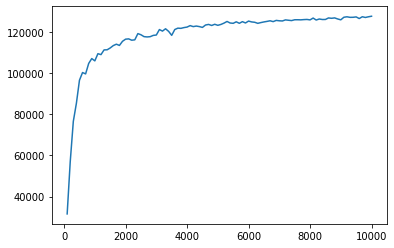

In [15]:
plt.plot(in_size, rate_v)

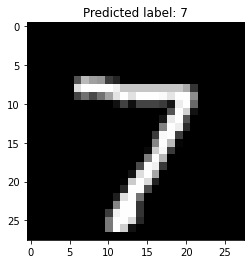

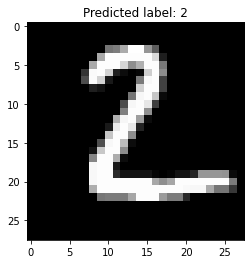

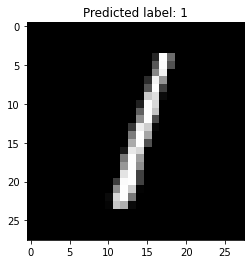

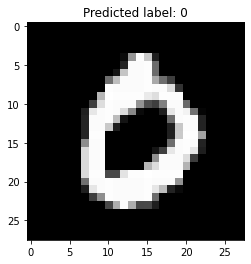

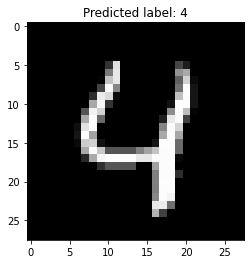

In [19]:
for i in range(5):
    img_title = ('Predicted label: %d' % np.argmax(np.array(y[i])))
    print_img(X_test[i], img_title)

In [20]:
y_alveo = y

Accuracy hls4ml: 0.9142
Accuracy FPGA: 0.9142


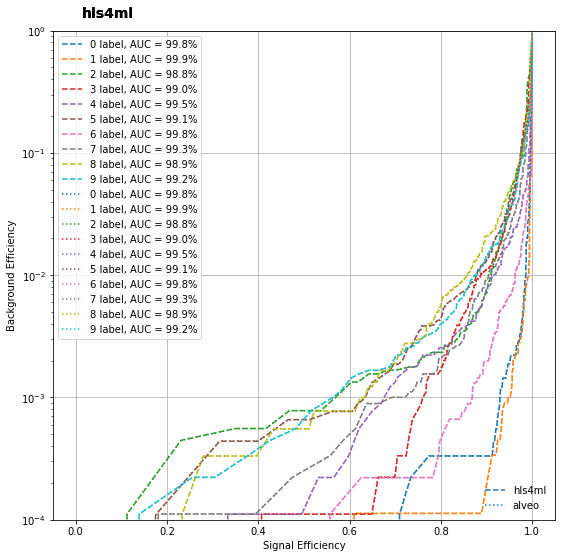

In [21]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
import plotting

#model_ref = load_model(MODEL_PATH + 'Keras_only/KERAS_check_best_model.h5')
#with tf.device('/cpu:0'):
#    y_ref = model_ref.predict(X_test)

y_test = np.load("../NN_train/MNIST_Test/Data/y_test.npy")
y_test.astype(np.float32)
y_hls = np.load("../NN_train/MNIST_Test/Data/y_hls_Dense.npy")
y_hls.astype(np.float32)

#print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))
print("Accuracy FPGA: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_alveo, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
#_ = plotting.makeRoc(y_test, y_ref, classes)
#plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle='--')
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_alveo   , ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle=':')

from matplotlib.lines import Line2D
lines = [#Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--'),
         Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['hls4ml', 'alveo'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

## Power measures

In [ ]:
from pynq import Device

sensors = Device.active_device.sensors
sensors

In [ ]:
from pynq.pmbus import DataRecorder

recorder = DataRecorder(sensors["12v_aux"].power,
                        sensors["12v_pex"].power,
                        sensors["vccint"].power)

In [ ]:
import pandas as pd

f = recorder.frame

In [ ]:
recorder.record(0.1)

In [ ]:
f.head()

In [ ]:
import plotly.graph_objs as go

layout = {
    'xaxis': {
        'title': 'Time (s)'
    },
    'yaxis': {
        'title': 'Power (W)',
        'rangemode': 'tozero',
        'autorange': True
    }
}

plot = go.FigureWidget(layout=layout)
plot

In [ ]:
def update_data(frame, start, end, plot):
    ranged = frame[start:end]
    average_ranged = frame[start-pd.tseries.offsets.Second(5):end]
    rolling = (average_ranged['12v_aux_power'] + average_ranged['12v_pex_power']).rolling(
        pd.tseries.offsets.Second(5)
    ).mean()[ranged.index]
    powers = pd.DataFrame(index=ranged.index)
    powers['board_power'] = ranged['12v_aux_power'] + ranged['12v_pex_power']
    powers['rolling'] = rolling
    data = [
        go.Scatter(x=powers.index, y=powers['board_power'], name="Board Power"),
        go.Scatter(x=powers.index, y=powers['rolling'], name="5 Second Avg")
    ]
    plot.update(data=data)


In [ ]:
import threading
import time

do_update = True

def thread_func():
    while do_update:
        now = pd.Timestamp.fromtimestamp(time.time())
        past = now - pd.tseries.offsets.Second(60)
        update_data(recorder.frame, past, now, plot)
        time.sleep(0.5)

from threading import Thread
t = Thread(target=thread_func)
t.start()

In [ ]:
do_update = False
t.join()
recorder.stop()